## 4.1 Understanding Convolution (15 pts)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
def convolution(x, w, b, stride, pad):
    """
    Forward Pass for a convolution layer.
    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width HH.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input.

    Output:
    - out: Output of the forward pass
    - x, w, b
    """
    # Your code starts here
    batch_size, chan_in, h_in, w_in = x.shape
    n_filter, chan_filter, h_filter, w_filter = w.shape
    h_out = ((h_in + 2*pad - h_filter)//stride) + 1
    w_out = ((w_in + 2*pad - w_filter)//stride) + 1

    out = np.zeros((h_out * w_out * n_filter, batch_size))
    w_col = w.reshape(n_filter, chan_filter*h_filter*w_filter)

    col = im2col_conv(x, h_filter, w_filter, pad, stride, h_out, w_out)
    tmp_output = np.dot(w_col, col).T+b
    print(tmp_output.shape)
    out = tmp_output.T.reshape(n_filter, h_out,w_out, batch_size)
    out = out.transpose(3,0,1,2)
    return out, x, w, b

def im2col_conv(x, h_filter, w_filter, pad, stride, h_out, w_out):
  # Zero-pad the input
    p = pad
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p,p)), mode='constant')
    k, i, j = get_im2col_indices(x.shape, h_filter, w_filter, pad,stride)
    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(h_filter * w_filter * C, -1)
    return cols

def get_im2col_indices(x_shape, field_height, field_width, pad=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    out_height = int((H + 2 * pad - field_height) / stride + 1)
    out_width = int((W + 2 * pad - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)
    return (k, i, j)

(80000, 2)
(2, 2, 200, 200)


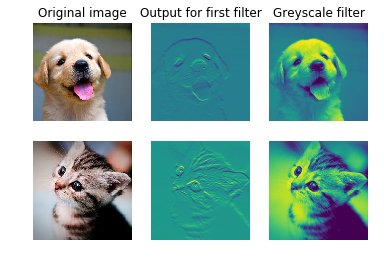

In [5]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# First filter (provided) 
w[0, 0, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Specify the second filter (gray-scale filter)(TODO)
w[1,0,:,:] = [[0,0,0], [0,0.299,0],[0,0,0]]
w[1,1,:,:] = [[0,0,0], [0,0.587,0],[0,0,0]]
w[1,2,:,:] = [[0,0,0], [0,0.114,0],[0,0,0]]
# Vector of biases. 
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out,x,w,b= convolution(x, w, b, 1,1)
print(out.shape)

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Output for first filter')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Greyscale filter')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

It looks like the first filter checks for edges, while the second makes it grayscaled. 
The im2col transformation was a technique in cs231, for assignment #2 (http://cs231n.github.io/assignments2015/assignment2/).

## 4.2 Dropout (5 pts)

In [6]:
def dropout(x, mode,p):
    """
    Performs the forward pass for (inverted) dropout.
    Inputs:
    - x: Input data, of any shape
    - p: Dropout parameter. We drop each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
    if the mode is test, then just return the input.
    Outputs:
    - out: Array of the same shape as x.
    """
    dropout = 1
    p=1-p
    if mode == 'train':
        # Your code starts here
        # During training randomly drop out neurons with probability P, here we create the mask that does this.
        dropout = (np.random.rand(*x.shape) < p) / p
    elif mode == 'test':
        # Your code starts here
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        pass
    return x*dropout

In [7]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out = dropout(x, 'train', p)
    out_test = dropout(x,'test',p)

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.0002078785
Mean of train-time output:  9.99084816276
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.300672
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078785
Mean of train-time output:  9.97791765876
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0002078785
Mean of train-time output:  9.99164074152
Mean of test-time output:  10.0002078785
Fraction of train-time output set to zero:  0.750232
Fraction of test-time output set to zero:  0.0



## 4.3 Batch Normalization (10 pts)

In [13]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.
    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:
    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.
    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #######################################################################
        sample_mean = np.mean(x,axis=0)
        sample_var = np.var(x,axis=0)
        x_hat = (x-sample_mean)/np.sqrt(sample_var+eps)
        y = (gamma*x_hat)+beta
        
        cache = (x, x_hat, sample_mean, sample_var, gamma, beta)
        out = y
        
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        # Test time batch norm using learned gamma/beta and calculated running mean/var.
        x_hat = (x-running_mean)/np.sqrt(running_var+eps)
        y = (gamma*x_hat)+beta
        
        out = y
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

### Batch Normalization Test

In [14]:
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  5.32907052e-17   7.04991621e-17   4.11476409e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


In [15]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [ 1.01531428  1.01238373  0.97819988]
